In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score 

In [2]:
#loading the dataset

#train 
X_train = pd.read_csv('mnist_train.csv')
Y_train = X_train['label'].values
X_train = X_train.drop(['label'],axis =1)
X_train = X_train.values
X_train = X_train.T
Y_train = np.reshape(Y_train,(1,-1))


#test
X_test = pd.read_csv('mnist_test.csv')
Y_test = X_test['label'].values
X_test = X_test.drop(['label'],axis = 1)
X_test = X_test.values 
X_test = X_test.T
Y_test = np.reshape(Y_test,(1,-1))

#normalizing 
X_train = X_train/255
X_test = X_test/255
print(Y_test.shape)

(1, 10000)


In [3]:
#one hot encoding the target values
digits = 10
examples = Y_train.shape[1]
Y_train = np.eye(digits)[Y_train.astype('int32')]
Y_train = Y_train.T
Y_train = Y_train.reshape(digits,examples)
print(Y_train[:,3])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# one hot encoding the test_target values
digits = 10
test_examples = Y_test.shape[1]
Y_test = np.eye(digits)[Y_test.astype('int32')]
Y_test = Y_test.T.reshape(digits,test_examples)
#Y_test = Y_test.reshape(digits,test_examples)
print(Y_test[:,3])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


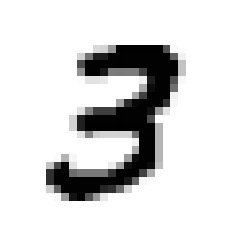

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [5]:
i = 7
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
 
print(Y_train[:,i])

In [6]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

In [7]:
def softmax(A_prev,W,b):
    ZL = np.dot(W,A_prev) + b
    AL = np.exp(ZL)/np.sum(np.exp(ZL),axis = 0)
    store = (W,A_prev,b,ZL)
    return AL,store

In [8]:
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    
    L = len(layer_dims)
    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros([layer_dims[l],1])
    return parameters    

In [9]:
def forward_propagation(A_prev,W,b):
    Z = np.dot(W,A_prev) + b
    A = sigmoid(Z)
    store = (W,A_prev,b,Z) #store is a tuple that stores information for back_propagation in the order(W,A_preb,b,Z)
    return A,store

In [10]:
def L_layer_forward(X_train,parameters):
    stores = []
    A = X_train
    
    L = len(parameters)//2
    
    for l in  range(1,L):    #starting from 1 and ending at L-1. Last element in the forward prop being A = A[L-1].
        A_prev = A
        A,store = forward_propagation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)])
        stores.append(store)
        
    #last layer is a sofmax acctivation layer and A = A[L-1]
    AL,store = softmax(A,parameters["W"+str(L)],parameters["b"+str(L)])
    
    stores.append(store)    #stores is a list from 0 to L-1
    return AL,stores

In [11]:
def cost_function(AL,Y_train):
    loss = np.sum(np.multiply(Y_train,np.log(AL)))
    m = Y_train.shape[1]
    total_cost = -(1/m)*loss
    
    return total_cost

In [12]:
def backward_propagation(dAl,store): #takes current dAl and current store(Wl,Al-1,bl,Zl)
    Wl,A_prev,bl,Zl = store
    m = A_prev.shape[1]
    
    dZl = np.multiply(dAl,(sigmoid(Zl)*(1-sigmoid(Zl))))
    dWl = np.dot(dZl,A_prev.T)/m
    dbl = np.sum(dZl,axis =1,keepdims= True)/m
    dA_prev = np.dot(Wl.T,dZl)
    
    return dWl,dbl,dA_prev

In [13]:
def L_layer_backward(AL,Y_train,stores):
    grads = {}
    L = len(stores)
    m = AL.shape[1]
    
    dZL = (AL-Y_train)
    current_store = stores[L-1]
    WL,A_prev,b,Z = current_store
    grads["dW"+str(L)] = np.dot(dZL,A_prev.T)/m
    grads["db"+str(L)] = np.sum(dZL,axis = 1,keepdims = True)/m
    grads["dA"+str(L-1)] = np.dot(WL.T,dZL)
    
    for l in reversed(range(L-1)): #from L-2 to 0
        current_store = stores[l]
        dW,db,dA_prev = backward_propagation(grads["dA"+str(l+1)],current_store)
        grads["dA"+str(l)] = dA_prev
        grads["dW"+str(l+1)] = dW
        grads["db"+str(l+1)] = db
        
    return grads

In [14]:
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*grads["db"+str(l+1)]
    return parameters
        

In [15]:
def random_mini_batches(X_train,Y_train,seed, mini_batch_size = 64):
    np.random.seed(seed)
    m = X_train.shape[1]
    mini_batches = []
    
    permutation = np.random.permutation(m)
    shuffled_X = X_train[:,permutation]
    shuffled_Y = Y_train[:,permutation]
    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m%mini_batch_size !=0:
        mini_batch_X = shuffled_X[:,(k+1)*mini_batch_size: (k+1)*mini_batch_size+m%mini_batch_size]
        mini_batch_Y = shuffled_Y[:,(k+1)*mini_batch_size: (k+1)*mini_batch_size+m%mini_batch_size]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [33]:
def model_with_mini_batch(X_train,Y_train,layer_dims,learning_rate,iterations):
    costs = []
    seed = 1
    m = X_train.shape[1]
    cost_avg = 0
    parameters = initialize_parameters(layer_dims)
    mini_batch_size = 64
    
    for i in range(0,iterations):
        seed = seed + 1
        mini_batches = random_mini_batches(X_train,Y_train,seed,mini_batch_size)
        cost_total = 0
        
        for minibatch in mini_batches:
            (minibatch_X,minibatch_Y) = minibatch
            AL, stores = L_layer_forward(minibatch_X,parameters)
            cost_total += cost_function(AL,minibatch_Y)
            grads = L_layer_backward(AL,minibatch_Y,stores)
            parameters = update_parameters(parameters,grads,learning_rate)
        cost_avg = cost_total/m
        
        if i %10 == 0:
            
            print("Cost after iteration %i: %f" %(i,cost_avg))
            costs.append(cost_avg)
    plt.plot((costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    
    return parameters

In [34]:
def model(X_train,Y_train,layer_dims,learning_rate,iterations):
    
    costs = []
    parameters = initialize_parameters(layer_dims)
    
    for i in range(iterations):
        AL,stores = L_layer_forward(X_train,parameters)
        cost = cost_function(AL,Y_train)
        grads = L_layer_backward(AL,Y_train,stores)
        parameters = update_parameters(parameters,grads,learning_rate)
        
        costs.append(cost)
        if i%100 == 0:
            print("Cost after iteration %i: %f" %(i,cost))
    
    plt.plot((costs))
    plt.ylabel("cost")
    plt.xlabel("iterations")
    plt.show()
    
    return parameters

Cost after iteration 0: 0.026303
Cost after iteration 10: 0.000793
Cost after iteration 20: 0.000261
Cost after iteration 30: 0.000065
Cost after iteration 40: 0.000030
Cost after iteration 50: 0.000018
Cost after iteration 60: 0.000013
Cost after iteration 70: 0.000010
Cost after iteration 80: 0.000008
Cost after iteration 90: 0.000007


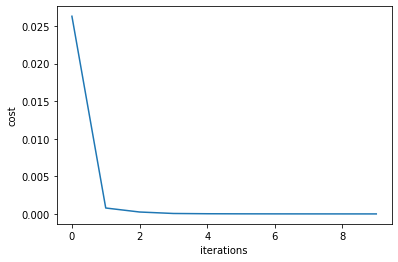

In [35]:
layer_dims = [784,64,64,10]
iterations = 100
learning_rate = 1 
parameters = model_with_mini_batch(X_train,Y_train,layer_dims,learning_rate,iterations)


In [36]:
AL,stores = L_layer_forward(X_test,parameters)
predictions = np.argmax(AL, axis =0)
labels = np.argmax(Y_test, axis = 0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions,labels))
accuracy_score(predictions,labels)*100

[[ 970    0    7    0    1    3    4    2    4    2]
 [   0 1125    3    0    0    0    1    1    0    1]
 [   1    2  999    7    3    0    4    5    4    0]
 [   0    1    9  980    1    6    0    6    5    2]
 [   0    0    1    2  953    1    2    2    3   15]
 [   2    1    0    9    1  871    4    1    5    3]
 [   2    2    2    0    5    6  939    0    3    0]
 [   1    2    5    6    1    0    0 1000    3    8]
 [   3    2    6    6    1    3    4    4  940    2]
 [   1    0    0    0   16    2    0    7    7  976]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       993
           1       0.99      0.99      0.99      1131
           2       0.97      0.97      0.97      1025
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       979
           5       0.98      0.97      0.97       897
           6       0.98      0.98      0.98       959
           7       0.97      0.97   

97.53

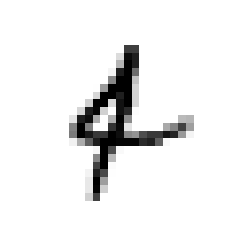

4


In [31]:
i = 300
plt.imshow(X_test[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
 
print(np.argmax(AL[:,i]))